<a href="https://colab.research.google.com/github/Betsabeh/Drug_traget_Deep/blob/main/DTI_5fusion_5cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#standard package
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
import math
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score, f1_score, precision_recall_curve, roc_curve

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tqdm.auto import tqdm



In [ ]:
def create_dict_from_csv(file_path):
    result_dict = {}
    All_id = []
    All_features =[]
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:
                cid = row[0].strip()
                feature = row[1].strip()
                result_dict[cid] = feature
                All_id.append(cid)
                All_features.append(feature)
    return result_dict, All_id, All_features


In [ ]:
Drug_Data, Drug_cid,Drug_Smiles=create_dict_from_csv('drug_info.csv')
Drug_cid = Drug_cid[1:]
Drug_Smiles =Drug_Smiles[1:]
Smiles_lenght =[]
for Smile in Drug_Smiles:
   Smiles_lenght.append(len(Smile))
print("max Smiles lenght=", np.max(Smiles_lenght))

NUM_Drugs= len(Drug_Smiles)
print(Drug_cid[0],':',Drug_Smiles[0])


Protein_Data, Protein_name, Protein_AA=create_dict_from_csv('prot_info.csv')
Protein_name = Protein_name[1:]
Protein_AA =Protein_AA[1:]
AAs_lenght = []
for AA in Protein_AA:
   AAs_lenght.append(len(AA))
print("max AA lenght=", np.max(AAs_lenght))
NUM_Protein= len(Protein_AA)
print(Protein_name[0],':',Protein_AA[0])

print('Number of Drugs=', NUM_Drugs, 'Number of Proteins=', NUM_Protein)


max Smiles lenght= 106
11485656 : CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=CC=C3)NN=C4N
max AA lenght= 2549
AAA61480.1|CLK1|CLK1 : MRHSKRTYCPDWDDKDWDYGKWRSSSSHKRRKRSHSSAQENKRCKYNHSKMCDSHYLESRSINEKDYHSRRYIDEYRNDYTQGCEPGHRQRDHESRYQNHSSKSSGRSGRSSYKSKHRIHHSTSHRRSHGKSHRRKRTRSVEDDEEGHLICQSGDVLSARYEIVDTLGEGAFGKVVECIDHKAGGRHVAVKIVKNVDRYCEAARSEIQVLEHLNTTDPNSTFRCVQMLEWFEHHGHICIVFELLGLSTYDFIKENGFLPFRLDHIRKMAYQICKSVNFLHSNKLTHTDLKPENILFVQSDYTEAYNPKIKRDERTLINPDIKVVDFGSATYDDEHHSTLVSTRHYRAPEVILALGWSQPCDVWSIGCILIEYYLGFTVFPTHDSKEHLAMMERILGPLPKHMIQKTRKRKYFHHDRLDWDEHSSAGRYVSRACKPLKEFMLSQDVEHERLFDLIQKMLEYDPAKRITLREALKHPFFDLLKKSI
Number of Drugs= 72 Number of Proteins= 442


In [ ]:
def protein_embedding(protein_sequences):
    """
    Embed a list of protein sequences (strings of amino acids) using ProtBert.

    Args:
        protein_sequences (list of str): List of protein amino acid sequences.

    Returns:
        embeddings (torch.Tensor): Embeddings of shape (batch_size, sequence_length, hidden_size).
    """

    torch.cuda.empty_cache()

    # Load the ProtBert tokenizer and mode
    model_name = "Rostlab/prot_bert" #"facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    model = AutoModel.from_pretrained(model_name)


    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #model.eval()

    max_seq_len = 1024

    processed_sequences = []
    for seq in protein_sequences:
        seq_truncated = seq[:max_seq_len] # Apply truncation here
        #processed_sequences.append(seq_truncated)
        processed_sequences.append(" ".join(list(seq_truncated)))

    #processed_sequences=kmer_tokenize(processed_sequences, k=2)
    batch_size = 8
    all_embeddings =[]
    num_Batches = math.ceil(NUM_Protein/batch_size)
    print(num_Batches)
    # Iterate through sequences in batches
    for i in tqdm(range(0, len(processed_sequences), batch_size), desc="Processing Batches"):
         #print(i)
         batch_sequences = processed_sequences[i:i + batch_size]
         # Tokenize the entire batch
         # padding='longest': Pads to the length of the longest sequence in the current batch.
         # truncation=True: Truncates sequences if they exceed the tokenizer's max input length (or max_seq_len if specified).
         inputs = tokenizer(batch_sequences,return_tensors="pt",padding='max_length', truncation=True,
                            max_length=max_seq_len).to(device)

         with torch.no_grad():
           outputs = model(**inputs)
           # Get the last hidden states (batch_size, sequence_length, hidden_size)
           batch_embeddings = outputs.last_hidden_state
           #print("Protein embeddings size =", batch_embeddings.shape)

         # Move embeddings to CPU and append to the list
         # Important: Only move to CPU if you don't need them on GPU for subsequent steps.
         # Moving to CPU frees up GPU memory.
         all_embeddings.append(batch_embeddings.cpu())

    # Concatenate all batch embeddings into a single tensor
    # This will result in a tensor of shape (total_sequences, max_length_in_batch, hidden_size)
    # where max_length_in_batch is the maximum length of a sequence in *any* batch,
    # because we padded 'longest' within each batch. If you need consistent length across ALL batches,
    # you'd need to pad to `max_seq_len` for every batch.
    final_embeddings_tensor = torch.cat(all_embeddings, dim=0)

    print(f"\nTotal protein embeddings tensor shape: {final_embeddings_tensor.shape}")
    print(f"Example of the first embedding's shape: {all_embeddings[0].shape}")
    return final_embeddings_tensor

    #---------------------------------------------------------------------------
    '''
    # Prepare the sequences by adding spaces between amino acids as required by ProtBert tokenizer
    sequences_with_spaces = [" ".join(list(seq)) for seq in protein_sequences]

    # Tokenize sequences (pads & truncates automatically)
    inputs = tokenizer(sequences_with_spaces, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the last hidden state (embeddings)
    embeddings = outputs.last_hidden_state
    print("Protein embeding size=",embeddings.shape)

    return embeddings'''



Protein_full_embeddings = protein_embedding(Protein_AA)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

56


Processing Batches:   0%|          | 0/56 [00:00<?, ?it/s]


Total protein embeddings tensor shape: torch.Size([442, 1024, 1024])
Example of the first embedding's shape: torch.Size([8, 1024, 1024])


In [ ]:
def drug_embedding(Drug_Smiles):
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MLM")
    model = AutoModel.from_pretrained("DeepChem/ChemBERTa-10M-MLM")
    #move to gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #tokenizer
    inputs = tokenizer(Drug_Smiles, return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)
      #print(outputs)

    embeddings = outputs.last_hidden_state # Or pooler_output depending on your needs
    print("Drug embeding size=",embeddings.shape) # Should be (batch_size, sequence_length, hidden_size)
    return embeddings

Drug_full_embeddings = drug_embedding(Drug_Smiles)



tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Drug embeding size= torch.Size([72, 89, 384])


In [ ]:
# 2. Define your desired embedding dimensions for the CNN
desired_drug_embed_dim = 64
desired_protein_embed_dim = 64

# Define the device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Create the projection layers
# These layers are initially created on CPU
drug_projection_layer = nn.Linear(Drug_full_embeddings.shape[-1], desired_drug_embed_dim)
protein_projection_layer = nn.Linear(Protein_full_embeddings.shape[-1], desired_protein_embed_dim)

# Move the projection layers to the same device as your embeddings (or where you want them to be)
drug_projection_layer.to(device)
protein_projection_layer.to(device)

# Move the embeddings to the same device as the projection layers
# (It's good practice to ensure both are on the same device)
Drug_full_embeddings = Drug_full_embeddings.to(device)
Protein_full_embeddings = Protein_full_embeddings.to(device)


# Now apply the projection layers
Drug_full_embeddings_projected = drug_projection_layer(Drug_full_embeddings)
Protein_full_embeddings_projected = protein_projection_layer(Protein_full_embeddings)
print("Drug projected shape:",Drug_full_embeddings_projected.shape)
print("Protein projected shape:",Protein_full_embeddings_projected.shape)


Drug projected shape: torch.Size([72, 89, 64])
Protein projected shape: torch.Size([442, 1024, 64])


In [ ]:
# --- 1. Read Data ---
csv_file_name ='Davis.csv'
raw_df = pd.read_csv(csv_file_name, header=None)
#print(f"\nLoaded raw CSV with shape: {raw_df.shape}")
#print("Raw CSV head:")
#print(raw_df.head())

# Extract drug CIDs from the first row (starting from the 5th column, index 4)
# Assuming the first 4 columns of the first row are empty or irrelevant for drug CIDs
drug_cids = raw_df.iloc[0, 4:].astype(str).tolist() # Convert to string to handle potential mixed types

# Extract protein identifiers from the 4th column (index 3) of rows 2 onwards (index 2 in 0-based)
# Assuming the combined ID is in the 4th column
protein_identifiers = raw_df.iloc[3:, 3].astype(str).tolist()
# Extract binding data (values start from row 2, column 4)
binding_data_matrix = raw_df.iloc[3:, 4:]

#print("CID=",drug_cids,'\n',"protein names=",protein_identifiers,'\n',binding_data_matrix)

# Convert wide format to long format
long_data = []
for p_idx, p_id in enumerate(protein_identifiers):
    for d_idx, d_cid in enumerate(drug_cids):
        binding_value = binding_data_matrix.iloc[p_idx, d_idx]
        binding_value = - math.log10(float(binding_value)/float(10**9))
        if pd.notna(binding_value): # Only include non-NaN binding values
            long_data.append({
                'drug_id': d_cid,
                'protein_name': p_id, # Using the combined protein identifier as 'protein_name'
                'binding_db': float(binding_value)
            })
        else :
            long_data.append({
                'drug_id': d_cid,
                'protein_name': p_id, # Using the combined protein identifier as 'protein_name'
                'binding_db': float(5.0) #-log10(10000/10^9)
            })

#print (long_data)
df_interactions = pd.DataFrame(long_data)
print(f"\nTransformed to long format DataFrame with {len(df_interactions)} interactions.")
print("First 5 rows of transformed interaction data:")
print(df_interactions.head())



Transformed to long format DataFrame with 31824 interactions.
First 5 rows of transformed interaction data:
    drug_id          protein_name  binding_db
0  11314340  AAA61480.1|CLK1|CLK1    8.853872
1  10074640  AAA61480.1|CLK1|CLK1    5.000000
2  11485656  AAA61480.1|CLK1|CLK1    5.050610
3  24889392  AAA61480.1|CLK1|CLK1    5.000000
4   6450551  AAA61480.1|CLK1|CLK1    5.000000


In [ ]:
# --- 2. Create Mappings from IDs/Names to Embedding Indices ---
# IMPORTANT ASSUMPTION: The order of drug CIDs extracted from the CSV
# matches the order of drugs in drug_full_embeddings (index 0 to 71).
# Similarly for protein identifiers and protein_full_embeddings.

drug_id_to_idx = {cid: i for i, cid in enumerate(drug_cids)}
protein_name_to_idx = {p_id: i for i, p_id in enumerate(protein_identifiers)}

# Map drug_id and protein_name in DataFrame to their respective indices
df_interactions['drug_idx'] = df_interactions['drug_id'].map(drug_id_to_idx)
df_interactions['protein_idx'] = df_interactions['protein_name'].map(protein_name_to_idx)

# Drop rows where mapping failed (if any drug_id or protein_name not found in embeddings)
df_interactions.dropna(subset=['drug_idx', 'protein_idx'], inplace=True)
df_interactions['drug_idx'] = df_interactions['drug_idx'].astype(int)
df_interactions['protein_idx'] = df_interactions['protein_idx'].astype(int)

print(f"\nAfter mapping, {len(df_interactions)} valid interactions remain.")
print("First 5 rows with mapped indices:")
print(df_interactions.head())
# We will directly use the full 2D embedding matrices for drugs and proteins.
# Drug_full_embeddings: (num_drugs, drug_seq_len, drug_embed_dim) -> (72, 89, 384)
# Protein_full_embeddings: (num_proteins, protein_seq_len, protein_embed_dim) -> (442, 512, 1024)

print(f"\nUsing full 2D drug embeddings shape: {Drug_full_embeddings_projected.shape}")
print(f"Using full 2D protein embeddings shape: {Protein_full_embeddings_projected.shape}")


After mapping, 31824 valid interactions remain.
First 5 rows with mapped indices:
    drug_id          protein_name  binding_db  drug_idx  protein_idx
0  11314340  AAA61480.1|CLK1|CLK1    8.853872         0            0
1  10074640  AAA61480.1|CLK1|CLK1    5.000000         1            0
2  11485656  AAA61480.1|CLK1|CLK1    5.050610         2            0
3  24889392  AAA61480.1|CLK1|CLK1    5.000000         3            0
4   6450551  AAA61480.1|CLK1|CLK1    5.000000         4            0

Using full 2D drug embeddings shape: torch.Size([72, 89, 64])
Using full 2D protein embeddings shape: torch.Size([442, 1024, 64])


In [ ]:
# --- 3. Initial Split for Test Set (held out) ---
# The test set will be held out and evaluated only once at the very end.
# K-Fold CV will be performed on the remaining train_val_data.
total_indices = df_interactions.index.tolist()
train_val_indices, test_indices = train_test_split(total_indices, test_size=0.20,
                                                   random_state=42, shuffle=True # Ensure shuffle for good split
)

df_train_val = df_interactions.loc[train_val_indices].reset_index(drop=True)
df_test = df_interactions.loc[test_indices].reset_index(drop=True)

print(f"\nTotal interactions: {len(df_interactions)}")
print(f"Train+Validation set size: {len(df_train_val)} samples")
print(f"Test set size (held out): {len(df_test)} samples")


Total interactions: 31824
Train+Validation set size: 25459 samples
Test set size (held out): 6365 samples


In [ ]:
# --- 4. Define a PyTorch Dataset Class ---
class DrugProteinDataset(Dataset):
    def __init__(self, df, drug_full_embeddings, protein_full_embeddings):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'drug_idx', 'protein_idx', and 'binding_db'.
            drug_full_embeddings (torch.Tensor): Full 2D drug embeddings (num_drugs, seq_len, embed_dim).
            protein_full_embeddings (torch.Tensor): Full 2D protein embeddings (num_proteins, seq_len, embed_dim).
        """
        self.df = df
        self.drug_embeddings_full = drug_full_embeddings
        self.protein_embeddings_full = protein_full_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row for the current index
        row = self.df.iloc[idx]

        # Get drug and protein indices
        drug_idx = row['drug_idx']
        protein_idx = row['protein_idx']

        # Retrieve the full 2D embedding matrices
        drug_embed_matrix = self.drug_embeddings_full[drug_idx].detach()
        protein_embed_matrix = self.protein_embeddings_full[protein_idx].detach()

        # Get the binding affinity value
        binding_affinity = torch.tensor(row['binding_db'], dtype=torch.float32)

        # For 2D CNN, you typically need an input channel dimension.
        # If your embeddings are already (Height, Width), a CNN expects (Channels, Height, Width).
        # We add a channel dimension of 1 if treating each as a single-channel image.
        drug_embed_matrix = drug_embed_matrix.unsqueeze(0) # Adds a channel dimension: (1, 89, 384)
        protein_embed_matrix = protein_embed_matrix.unsqueeze(0) # Adds a channel dimension: (1, 512, 1024)

        return drug_embed_matrix, protein_embed_matrix, binding_affinity


#Create the full dataset from which folds will be drawn
full_dataset_for_cv = DrugProteinDataset(df_train_val, Drug_full_embeddings_projected, Protein_full_embeddings_projected)
test_dataset_final = DrugProteinDataset(df_test, Drug_full_embeddings_projected, Protein_full_embeddings_projected)

print(f"\nDataset for CV created with {len(full_dataset_for_cv)} samples.")
print(f"Final Test Dataset created with {len(test_dataset_final)} samples.")


Dataset for CV created with 25459 samples.
Final Test Dataset created with 6365 samples.


In [ ]:
# --- 5. Define the 2D CNN Model in PyTorch ---
class DrugProteinCNN(nn.Module):
  def __init__(self, drug_input_shape, protein_input_shape,
                 common_channels=8, common_height=4, common_width=4): # Significantly reduced common feature map size
        super(DrugProteinCNN, self).__init__()

        self.common_channels = common_channels
        self.common_height = common_height
        self.common_width = common_width

        # Drug Branch CNN (fewer filters, more aggressive pooling)
        # Input shape: (Batch_size, 1, 89, 384)
        self.drug_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=(2, 2)), # (B, 8, 44, 192)

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)), # (B, 16, 22, 96),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)) # (B, 16, 22, 96)
        )
        self.drug_adaptive_pool = nn.AdaptiveAvgPool2d((self.common_height, self.common_width))
        self.drug_channel_adjust = nn.Conv2d(in_channels=32, out_channels=self.common_channels, kernel_size=(1, 1))

        # Protein Branch CNN (fewer filters, more aggressive pooling)
        # Input shape: (Batch_size, 1, 512, 1024)
        self.protein_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5), padding='same'), # Reduced out_channels
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(4, 4)), # More aggressive pooling (B, 16, 128, 256)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            nn.BatchNorm2d(32),
            #nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)), # (B, 32, 64, 128)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            nn.BatchNorm2d(64),
            #nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)), # (B, 64, 32, 64)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding='same'), # Reduced out_channels
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2, 2)) # (B, 64, 32, 64)
        )
        self.protein_adaptive_pool = nn.AdaptiveAvgPool2d((self.common_height, self.common_width))
        self.protein_channel_adjust = nn.Conv2d(in_channels=128, out_channels=self.common_channels, kernel_size=(1, 1))

        # Calculate the flattened size for each branch after projection
        self.single_branch_flatten_size = self.common_channels * self.common_height * self.common_width
        print(f"Single branch flattened size (after projection): {self.single_branch_flatten_size}")

        # Fully Connected Layers for combined features (after concatenation)
        # Input size is now 2 * single_branch_flatten_size because of concatenation
        self.fc_add = nn.Sequential(
            nn.Linear( self.single_branch_flatten_size, 32), # Significantly reduced FC layer size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.6),
            #nn.Linear(16, 16), # Reduced FC layer size
            #nn.BatchNorm1d(16),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(32, 1) # Output a single binding affinity value
        )
        self.fc_concat = nn.Sequential(
            nn.Linear( 2*self.single_branch_flatten_size, 16), # Significantly reduced FC layer size
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.6),
            #nn.Linear(16, 8), # Reduced FC layer size
            #nn.BatchNorm1d(8),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(16, 1) # Output a single binding affinity value
        )
        self.fc_mul = nn.Sequential(
            nn.Linear( self.single_branch_flatten_size, 32), # Significantly reduced FC layer size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.6),
            #nn.Linear(16, 16), # Reduced FC layer size
            #nn.BatchNorm1d(16),
            #nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(32, 1) # Output a single binding affinity value
        )
        self.bilinear_layer = nn.Bilinear(self.single_branch_flatten_size, self.single_branch_flatten_size,16)
        self.fc_outer_product = nn.Sequential(
            nn.Linear(16, 16), # Outer product is large, reduce
            nn.BatchNorm1d(16), nn.ReLU(), nn.Dropout(0.7),
            nn.Linear(16, 1) # Intermediate prediction
        )
        # NEW: Prediction Head for Max Fusion
        self.fc_max = nn.Sequential(
            nn.Linear(self.single_branch_flatten_size, 32), # Max fusion output has same dim as input features
            nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(0.6),
            nn.Linear(32, 1) # Intermediate prediction
        )

        self.ensemble= nn.Sequential(
            nn.Linear(5,1)
        )



  def forward(self, drug_matrices, protein_matrices):
        # Process drug matrices
        drug_features = self.drug_cnn(drug_matrices)
        drug_features = self.drug_adaptive_pool(drug_features)
        drug_features = self.drug_channel_adjust(drug_features)
        drug_features_flattened = torch.flatten(drug_features, 1) # Flatten for FC layers

        # Process protein matrices
        protein_features = self.protein_cnn(protein_matrices)
        protein_features = self.protein_adaptive_pool(protein_features)
        protein_features = self.protein_channel_adjust(protein_features)
        protein_features_flattened = torch.flatten(protein_features, 1) # Flatten for FC layers

        # --- Fusion Paths ---
        # Concatenate features from both branches
        combined_features1 = torch.add(drug_features_flattened, protein_features_flattened)
        combined_features2 = torch.cat((drug_features_flattened, protein_features_flattened), dim=1)
        combined_features3 = torch.mul(drug_features_flattened, protein_features_flattened)
        combined_features4 = self.bilinear_layer(drug_features_flattened, protein_features_flattened)

        #outer_product_features = torch.bmm(drug_features_flattened.unsqueeze(2), protein_features_flattened.unsqueeze(1))
        #combined_features4 = torch.flatten(outer_product_features, 1) # Flatten to (B, D*D)
        # NEW: 5. Max Fusion
        combined_features5 = torch.max(drug_features_flattened, protein_features_flattened)



        # Pass through fully connected layers for prediction
        output1 = self.fc_add(combined_features1)
        output2 = self.fc_concat(combined_features2)
        output3 = self.fc_mul(combined_features3)
        output4 = self.fc_outer_product(combined_features4)
        output5 = self.fc_max(combined_features5)
        all_outputs = torch.cat((output1, output2,  output3, output4,output5), dim=1)
        output =  self.ensemble(all_outputs)
        return output




In [ ]:
# --- Evaluation Metrics Functions ---
def concordance_index(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    valid_indices = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]
    n = len(y_true)
    if n < 2: return 0.0
    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs_pred = 0
    for i in range(n):
        for j in range(i + 1, n):
            if y_true[i] == y_true[j]:
                if y_pred[i] == y_pred[j]: tied_pairs_pred += 1
                continue
            if (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]) or \
               (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]):
                concordant_pairs += 1
            elif (y_true[i] > y_true[j] and y_pred[i] < y_pred[j]) or \
                 (y_true[i] < y_true[j] and y_pred[i] > y_pred[j]):
                discordant_pairs += 1
            else: tied_pairs_pred += 1
    total_comparable_pairs = concordant_pairs + discordant_pairs + tied_pairs_pred
    if total_comparable_pairs == 0: return 0.0
    ci = (concordant_pairs + 0.5 * tied_pairs_pred) / total_comparable_pairs
    return ci

def r2m_score(y_true, y_pred):
    # Calculate R2 (coefficient of determination)
    r2 = r2_score(y_true, y_pred)

    # Calculate R0^2 (R-squared without intercept)
    # This requires fitting a linear model without intercept
    from sklearn.linear_model import LinearRegression
    lr_no_intercept = LinearRegression(fit_intercept=False)
    lr_no_intercept.fit(y_pred.reshape(-1, 1), y_true)
    r0_2 = lr_no_intercept.score(y_pred.reshape(-1, 1), y_true)

    # Calculate r2m
    if r2 < 0 or r0_2 < 0: # Handle cases where R2 or R0^2 might be negative (e.g., very poor fit)
        return 0.0 # Or np.nan, depending on how you want to handle it

    r2m = r2 * (1 - np.sqrt(np.abs(r2 - r0_2)))
    return r2m

def AUC_AUPR(y_true, y_pred, binding_threshold=7):
    print(f"\n--- Classification Metrics (using threshold={binding_threshold} for 'bound' vs 'not bound') ---")
    # Convert true values and predictions to binary labels
    true_binary_labels = (np.array(y_true) >= binding_threshold).astype(int)
    # For predictions, we often use the raw prediction values as 'scores' for AUC/AUPR
    predicted_binary_labels = (np.array(y_pred) >= binding_threshold).astype(int)
    # AUC (Area Under the Receiver Operating Characteristic Curve)
    try:
       auc_score = roc_auc_score(true_binary_labels, y_pred) # Use raw predictions as scores
    except ValueError as e:
       print(f"Could not calculate AUC: {e}. This might happen if all true labels are the same class.")
    # AUPR (Area Under the Precision-Recall Curve)
    try:
        aupr_score = average_precision_score(true_binary_labels, y_pred) # Use raw predictions as scores
    except ValueError as e:
        print(f"Could not calculate AUPR: {e}. This might happen if all true labels are the same class.")

    return auc_score, aupr_score


In [ ]:
# Train function
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        return torch.sqrt(self.mse(pred, target))


def train_model(model, train_loader, val_loader,num_train , num_val,lrate, num_epochs,   early_stopping_patience = 25):
  criterion = RMSELoss()
  optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=1e-3)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

  train_losses = []
  val_losses = []
  best_val_loss = float('inf')
  #print("\n--- Starting Training ---")
  patience_counter = 0

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # CORRECTED LINE: Unpack only 3 tensors from the DataLoader
    for drug_matrices, protein_matrices, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
        drug_matrices = drug_matrices.to(device)
        protein_matrices = protein_matrices.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # CORRECTED LINE: Pass only 2 input tensors to the model
        outputs = model(drug_matrices, protein_matrices)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * drug_matrices.size(0)


    epoch_train_loss = running_loss / num_train
    train_losses.append(epoch_train_loss)


    # --- Validation Step ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
           # CORRECTED LINE: Unpack only 3 tensors from the DataLoader
           for drug_matrices, protein_matrices, targets in val_loader:
              drug_matrices = drug_matrices.to(device)
              protein_matrices = protein_matrices.to(device)
              targets = targets.to(device)
              # CORRECTED LINE: Pass only 2 input tensors to the model
              outputs = model(drug_matrices, protein_matrices)
              loss = criterion(outputs.squeeze(), targets)
              val_loss += loss.item() * drug_matrices.size(0)

    val_loss /= num_val
    val_losses.append(val_loss)
    # Print progress less frequently during CV to avoid overwhelming output
    if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == num_epochs - 1:
             print(f"Fold {fold+1} Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pt')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered for Fold {fold+1} at epoch {epoch+1}.")
            break

  # --- Plotting Loss Curves ---
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title(f"Training and Validation fold {fold+1} Loss Over Epochs")
  plt.xlabel('Epoch')
  plt.ylabel('Loss (RMSE)')
  plt.legend()
  plt.grid(True)
  plt.show()
  return model, train_losses, val_losses

In [ ]:
# test function
def test_model(model, test_dataset_final, batch_size, binding_threshold=7):
  # --- Evaluate the best model of the current fold on the FINAL held-out TEST SET ---
    model.to(device)
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pt', map_location=device))
    test_loader_final = DataLoader(test_dataset_final, batch_size=batch_size_loader, shuffle=False)
    model.eval()


    predictions = []
    true_values = []
    with torch.no_grad():
        for drug_matrices, protein_matrices, targets in test_loader_final:
            drug_matrices = drug_matrices.to(device)
            protein_matrices = protein_matrices.to(device)
            targets = targets.to(device)
            outputs = model(drug_matrices, protein_matrices)
            predictions.extend(outputs.squeeze().cpu().numpy())
            true_values.extend(targets.cpu().numpy())

    # Calculate and store metrics for the current fold's test set
    test_rmse = np.sqrt(mean_squared_error(true_values, predictions))
    test_r2 = r2_score(true_values, predictions)
    test_ci = concordance_index(true_values, predictions)
    test_auc, test_aupr = AUC_AUPR(true_values,predictions, binding_threshold)
    return test_rmse, test_r2, test_ci, test_auc, test_aupr



--- Starting 5-Fold Cross-Validation ---

--- Fold 1/5 ---
number of train samples: 20367
number of vaildation samples: 5092
Single branch flattened size (after projection): 64


Epoch 1/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [1/200], Train Loss: 4.0522, Val Loss: 1.6088


Epoch 2/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 3/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 4/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 5/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [5/200], Train Loss: 1.1989, Val Loss: 0.7096


Epoch 6/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 7/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 8/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 9/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 10/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [10/200], Train Loss: 0.9991, Val Loss: 0.6572


Epoch 11/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 12/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 13/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 14/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 15/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [15/200], Train Loss: 0.8605, Val Loss: 0.6144


Epoch 16/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 17/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 18/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 19/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 20/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [20/200], Train Loss: 0.7606, Val Loss: 0.5840


Epoch 21/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 22/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 23/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 24/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 25/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [25/200], Train Loss: 0.6796, Val Loss: 0.5548


Epoch 26/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 27/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 28/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 29/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 30/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [30/200], Train Loss: 0.6171, Val Loss: 0.5498


Epoch 31/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 32/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 33/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 34/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 35/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [35/200], Train Loss: 0.5532, Val Loss: 0.5316


Epoch 36/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 37/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 38/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 39/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 40/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [40/200], Train Loss: 0.5117, Val Loss: 0.5318


Epoch 41/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 42/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 43/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 44/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 45/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [45/200], Train Loss: 0.4810, Val Loss: 0.5076


Epoch 46/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 47/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 48/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 49/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 50/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [50/200], Train Loss: 0.4603, Val Loss: 0.5135


Epoch 51/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 52/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 53/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 54/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 55/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [55/200], Train Loss: 0.4195, Val Loss: 0.4910


Epoch 56/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 57/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 58/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 59/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 60/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [60/200], Train Loss: 0.4053, Val Loss: 0.4927


Epoch 61/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 62/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 63/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 64/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 65/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [65/200], Train Loss: 0.3967, Val Loss: 0.4972


Epoch 66/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 67/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 68/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 69/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 70/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [70/200], Train Loss: 0.3931, Val Loss: 0.5042


Epoch 71/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 72/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 73/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 74/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 75/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [75/200], Train Loss: 0.3770, Val Loss: 0.4967


Epoch 76/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 77/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 78/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 79/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 80/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [80/200], Train Loss: 0.3598, Val Loss: 0.4923


Epoch 81/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 82/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 83/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 84/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 85/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [85/200], Train Loss: 0.3543, Val Loss: 0.4981


Epoch 86/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 87/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 88/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 89/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 90/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [90/200], Train Loss: 0.3568, Val Loss: 0.4894


Epoch 91/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 92/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 93/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 94/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 95/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [95/200], Train Loss: 0.3484, Val Loss: 0.4900


Epoch 96/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 97/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 98/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 99/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 100/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [100/200], Train Loss: 0.3507, Val Loss: 0.4889


Epoch 101/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 102/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 103/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 104/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 105/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 1 Epoch [105/200], Train Loss: 0.3492, Val Loss: 0.4936


Epoch 106/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 107/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 108/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Early stopping triggered for Fold 1 at epoch 108.


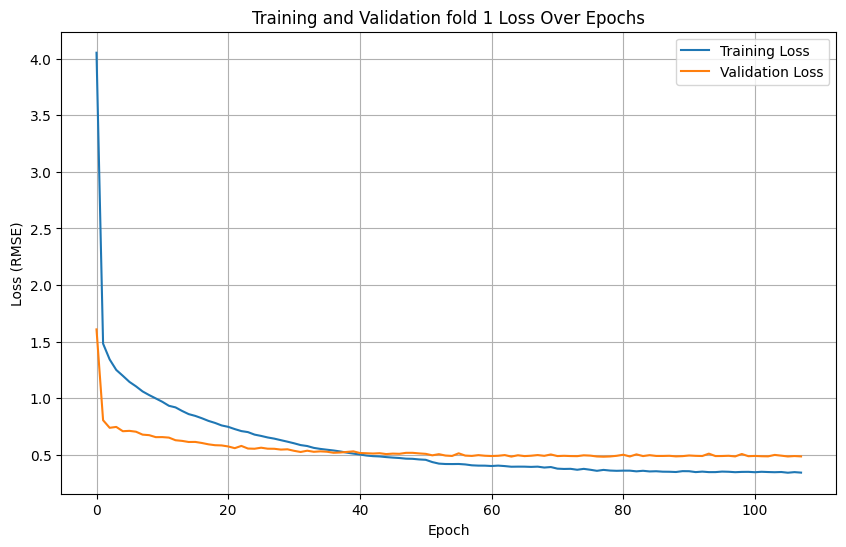

Single branch flattened size (after projection): 64
Evaluating best model from Fold 1 on the final Test Set...

--- Classification Metrics (using threshold=7.0 for 'bound' vs 'not bound') ---
Fold 1 Test Results: RMSE=0.4942, R2=0.6731, CI=0.8703, AUPR=0.7510, AUC=0.9556

--- Fold 2/5 ---
number of train samples: 20367
number of vaildation samples: 5092
Single branch flattened size (after projection): 64


Epoch 1/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Fold 2 Epoch [1/200], Train Loss: 3.8816, Val Loss: 1.6075


Epoch 2/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 3/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 4/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

Epoch 5/200 Training:   0%|          | 0/1273 [00:00<?, ?it/s]

In [ ]:
# --- Main Cross-Validation Loop ---
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store results for each fold
all_fold_train_losses = []
all_fold_val_losses = []
all_fold_test_rmses = []
all_fold_test_r2s = []
all_fold_test_cis = []
all_fold_test_auprs = []
all_fold_test_auc = []

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (from your Table I)
num_epochs = 200
learning_rate = 0.0001
batch_size_loader = 16 # As per your Table I
binding_threshold=7
early_stopping_patience = 30

# Model specific parameters (from your Table I)
model_common_channels = 4
model_common_height = 4
model_common_width = 4


# Classification threshold for AUPR/F1
binding_threshold = 7.0 # pKd >= 7 for active

print(f"\n--- Starting {num_folds}-Fold Cross-Validation ---")

for fold, (train_indices_fold, val_indices_fold) in enumerate(kf.split(full_dataset_for_cv)):
    print(f"\n--- Fold {fold+1}/{num_folds} ---")
    '''if fold == 0:
      all_fold_test_rmses.append(0.5098)
      all_fold_test_r2s.append(0.6521)
      all_fold_test_cis.append(0.8735)
      all_fold_test_auprs.append(0.7254)
      all_fold_test_auc.append(0.952)
      continue
    if fold == 1:
      all_fold_test_rmses.append(0.5064)
      all_fold_test_r2s.append(0.6567)
      all_fold_test_cis.append(0.8711)
      all_fold_test_auprs.append(0.7493)
      all_fold_test_auc.append(0.9534)
      continue
    '''
    # Create Subset datasets for the current fold
    train_subset = Subset(full_dataset_for_cv, train_indices_fold)
    val_subset = Subset(full_dataset_for_cv, val_indices_fold)
    num_train = len(train_subset)
    print("number of train samples:",num_train)
    num_val = len(val_subset)
    print("number of vaildation samples:", num_val)

    # Create DataLoaders for the current fold
    train_loader_fold = DataLoader(train_subset, batch_size=batch_size_loader, shuffle=True)
    val_loader_fold = DataLoader(val_subset, batch_size=batch_size_loader, shuffle=False)


    # Instantiate a NEW model for each fold
    # Get input shapes from the dataset's first item (from the full_dataset_for_cv)
    sample_drug_matrix, sample_protein_matrix, _ = full_dataset_for_cv[0]
    drug_input_shape = sample_drug_matrix.shape
    protein_input_shape = sample_protein_matrix.shape

    model = DrugProteinCNN(drug_input_shape, protein_input_shape,
                           common_channels=model_common_channels,
                           common_height=model_common_height,
                           common_width=model_common_width)
    model.to(device)

    trained_model, fold_train_losses, fold_val_losses = train_model(model, train_loader_fold, val_loader_fold,
                                                                    num_train , num_val,learning_rate,
                                                                    num_epochs, early_stopping_patience)
    all_fold_train_losses.append(fold_train_losses)
    all_fold_val_losses.append(fold_val_losses)

    # test best model
    loaded_model_fold = DrugProteinCNN(drug_input_shape, protein_input_shape,
                                       common_channels=model_common_channels,
                                       common_height=model_common_height,
                                       common_width=model_common_width)
    print(f"Evaluating best model from Fold {fold+1} on the final Test Set...")
    test_rmse, test_r2, test_ci, test_auc, test_aupr = test_model(loaded_model_fold, test_dataset_final, batch_size_loader, binding_threshold)
    all_fold_test_rmses.append(test_rmse)
    all_fold_test_r2s.append(test_r2)
    all_fold_test_cis.append(test_ci)
    all_fold_test_auprs.append(test_aupr)
    all_fold_test_auc.append(test_auc)
    print(f"Fold {fold+1} Test Results: RMSE={test_rmse:.4f}, R2={test_r2:.4f}, CI={test_ci:.4f}, AUPR={test_aupr:.4f}, AUC={test_auc:.4f}")
    torch.save(all_fold_test_rmses, f'RMSE_model_fold_{fold+1}.pt')
    torch.save(all_fold_test_r2s, f'RMSE_model_fold_{fold+1}.pt')
    torch.save(all_fold_test_cis, f'RMSE_model_fold_{fold+1}.pt')
    torch.save(all_fold_test_auprs, f'RMSE_model_fold_{fold+1}.pt')
    torch.save(all_fold_test_auc, f'RMSE_model_fold_{fold+1}.pt')
# --- Summarize Cross-Validation Results ---
print("\n--- Cross-Validation Summary ---")
print(f"Average Test RMSE: {np.mean(all_fold_test_rmses):.4f} ± {np.std(all_fold_test_rmses):.4f}")
print(f"Average Test R2: {np.mean(all_fold_test_r2s):.4f} ± {np.std(all_fold_test_r2s):.4f}")
print(f"Average Test CI: {np.mean(all_fold_test_cis):.4f} ± {np.std(all_fold_test_cis):.4f}")
print(f"Average Test AUPR: {np.nanmean(all_fold_test_auprs):.4f} ± {np.nanstd(all_fold_test_auprs):.4f}") # Use nanmean/nanstd for AUPR/F1
print(f"Average Test F1: {np.nanmean(all_fold_test_auc):.4f} ± {np.nanstd(all_fold_test_auc):.4f}")

# --- Plotting Loss Curves for all folds ---
plt.figure(figsize=(12, 8))
for i, (train_losses, val_losses) in enumerate(zip(all_fold_train_losses, all_fold_val_losses)):
    plt.plot(train_losses, label=f'Fold {i+1} Train Loss', alpha=0.7)
    plt.plot(val_losses, label=f'Fold {i+1} Val Loss', linestyle='--', alpha=0.7)
plt.title('Training and Validation Loss Over Epochs (All Folds)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

print("\nCross-validation complete!")



